In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
np.__version__

'1.26.1'

In [14]:
pd.__version__

'2.1.1'

In [2]:
# 載入資料
import zipfile
url='../datasets/bike+sharing+dataset.zip'
zip_file=zipfile.ZipFile(url)
df_raw=pd.read_csv(zip_file.open('day.csv'),parse_dates=[1])
zip_file.close()

In [3]:
df=df_raw.copy()
df=df[['dteday','registered']]
df.columns=['ds','y']
df.head()

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      731 non-null    datetime64[ns]
 1   y       731 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [5]:
# 使用FaceBook 的Prophet套件
# 以2012/11/1為分界點
mday=pd.to_datetime('2012-11-1')

# 分割
x_train=df.query('ds<@mday')
x_test=df.query('ds >= @mday')

In [6]:
x_train.tail()

,ds,y
665,2012-10-27,5209
666,2012-10-28,3461
667,2012-10-29,20
668,2012-10-30,1009
669,2012-10-31,5147


In [7]:
x_test.head()

,ds,y
670,2012-11-01,5520
671,2012-11-02,5229
672,2012-11-03,4109
673,2012-11-04,3906
674,2012-11-05,4881


In [8]:
# 用2011/01/01 - 2012/10/31 訓練模型
from prophet import Prophet
ml=Prophet(yearly_seasonality=True,weekly_seasonality=True,
           daily_seasonality=False,seasonality_mode='multiplicative')

ml.fit(x_train)

C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# 建立預測用資料
# 2012/11/01 -2012/12/31(61天)
future1=ml.make_future_dataframe(periods=61,freq='D')
display(future1.head())
future1.tail()

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [10]:
# 預測
fcst1=ml.predict(future1)

C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

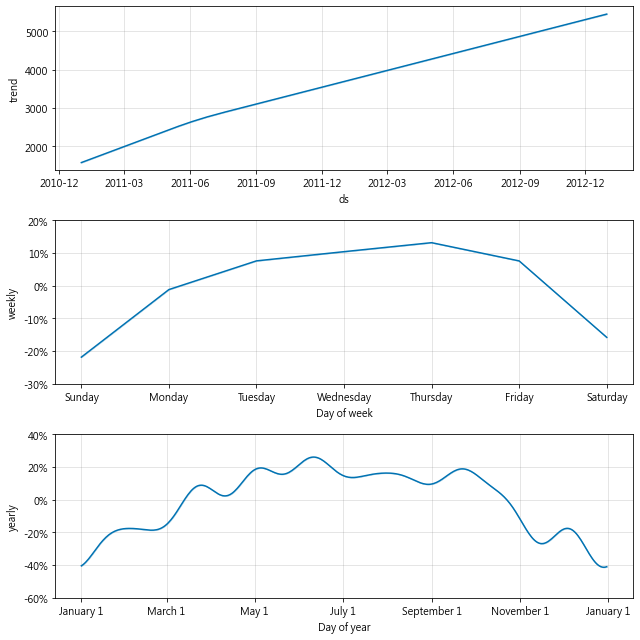

In [ ]:
# 繪製各元素圖形
# 長期趨勢、週期循環、年循環
fig=ml.plot_components(fcst1)
plt.show()

C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


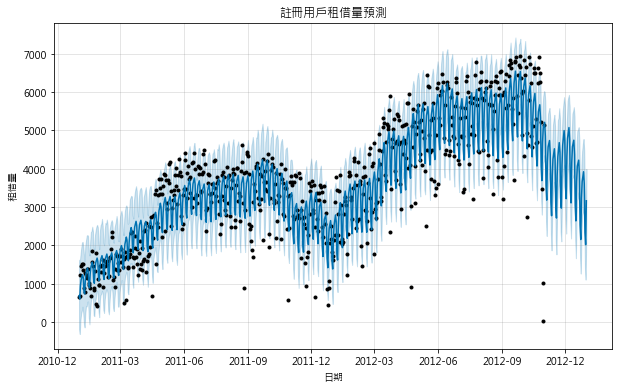

In [15]:
# 使用演算法內建函式,繪製預測結果圖形
fig,ax=plt.subplots(figsize=(10,6))

ml.plot(fcst1,ax=ax)
ax.set_title('註冊用戶租借量預測')
ax.set_xlabel('日期')
ax.set_ylabel('租借量')

plt.show()

In [45]:
# 計算R2
ypred1=fcst1.iloc[-61:,18].values
ytest1=x_test['y'].values

# 計算R2
from sklearn.metrics import r2_score
score=r2_score(ytest1,ypred1)
print(f'R2:{score:.4f}')


R2:0.3724


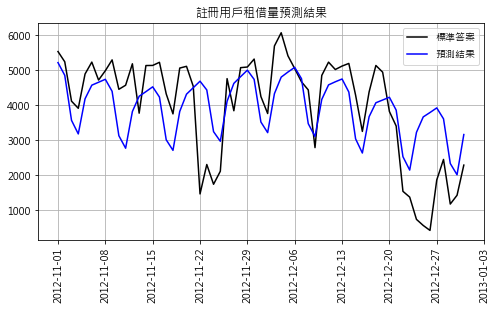

In [49]:
# 繪製時間序列圖
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(8,4))
datasets_test=x_test['ds']
ax.plot(datasets_test,ytest1,label='標準答案',c='k')
ax.plot(datasets_test,ypred1,label='預測結果',c='b')

# X座標
# 顯示每星期四
weeks=mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(axis='x',rotation=90)

# 其他設置
ax.grid()
ax.legend()
ax.set_title('註冊用戶租借量預測結果')
plt.show()

In [70]:
# 調整模型
# 加入國定假日因素
# 取國定假日日期
holiday=df_raw.loc[df_raw['holiday']==1,'dteday'].values

# 製作國定假日資料框,並假定國定假日對於前後日期,完全無影響
df_holiday=pd.DataFrame({'holiday':'holi',
                         'ds':holiday,
                         'lower_window':0,
                         'upper_window':0})

display(df_holiday.head())
df_holiday.tail()

,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [82]:
# 訓練有國定假日的模型
m2=Prophet(yearly_seasonality=True,weekly_seasonality=True
           ,daily_seasonality=False,holidays=df_holiday
           ,seasonality_mode='multiplicative')

m2.fit(x_train)

fcst2=m2.predict(future1)

15:59:08 - cmdstanpy - INFO - Chain [1] start processing
15:59:08 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

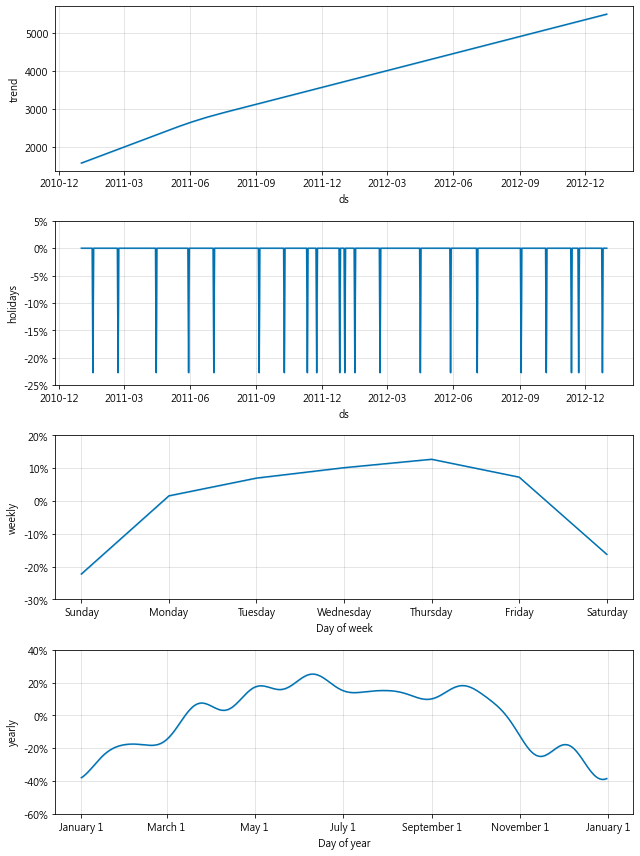

In [83]:
# 繪製各元素圖形
fig2=m2.plot_components(fcst2)
plt.show()

In [99]:
# R2
ypred2=fcst2[-61:]['yhat'].values
ytest2=x_test['y'].values

#from sklearn.metrics import r2_score
score2=r2_score(ytest2,ypred2)
print(f'm2_R2:{score2:.4f}')

m2_R2:0.4146


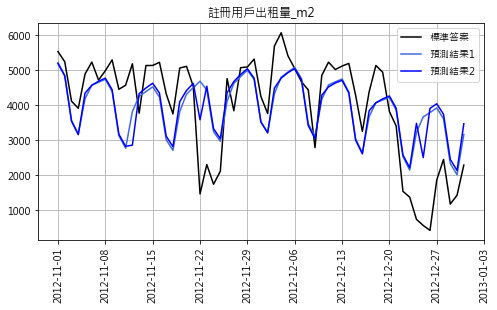

In [102]:
# 繪圖
#import matplotlib.datesas mdates
fig,ax=plt.subplots(figsize=(8,4))
datasets_test=x_test['ds']
ax.plot(datasets_test,ytest2,label='標準答案',c='k')
ax.plot(datasets_test,ypred1,label='預測結果1',c='royalblue')
ax.plot(datasets_test,ypred2,label='預測結果2',c='b')

weeks=mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(axis='x',rotation=90)

ax.grid()
ax.legend()
ax.set_title('註冊用戶出租量_m2')
plt.show()

In [114]:
# 調整2
# 增加 風速,氣溫,濕度,天氣等因素
df2=pd.concat([df,df_raw[['weathersit','temp','windspeed','hum']]],axis=1)
mday=pd.to_datetime('2012-11-01')
x2_train=df2.query('ds<@mday')
x2_test=df2.query('ds>=@mday')
x2_train.tail()

,ds,y,weathersit,temp,windspeed,hum
665,2012-10-27,5209,2,0.530000,0.235692,0.720000
666,2012-10-28,3461,2,0.477500,0.398008,0.694583
667,2012-10-29,20,3,0.440000,0.358200,0.880000
668,2012-10-30,1009,2,0.318182,0.213009,0.825455
669,2012-10-31,5147,2,0.357500,0.166667,0.666667


In [112]:
# m3
m3=Prophet(yearly_seasonality=True,weekly_seasonality=True,
          daily_seasonality=False,holidays=df_holiday,
          seasonality_mode='multiplicative')

# 新增因素納入模型
m3.add_regressor('weathersit')
m3.add_regressor('temp')
m3.add_regressor('windspeed')
m3.add_regressor('hum')

m3.fit(x2_train)


17:20:08 - cmdstanpy - INFO - Chain [1] start processing
17:20:09 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
# 預測
future3=df2[['ds','weathersit','temp','windspeed','hum']]
fcst3=m3.predict(future3)

C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ininl\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

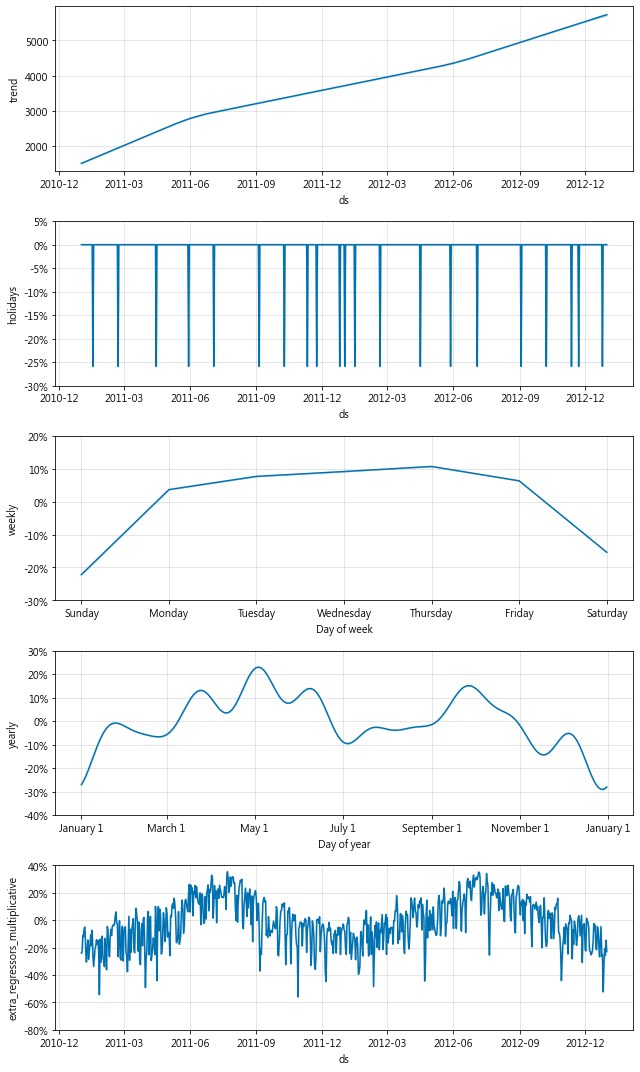

In [117]:
# 繪圖
fig3=m3.plot_components(fcst3)
plt.show()

In [120]:
# R2_m3
ytest3=x2_test['y'].values
ypred3=fcst3[-61:]['yhat'].values
#from sklearn.metrics import r2_score
score3=r2_score(ytest3,ypred3)
print(f'm3_R2:{score3:.4f}')

m3_R2:0.6200


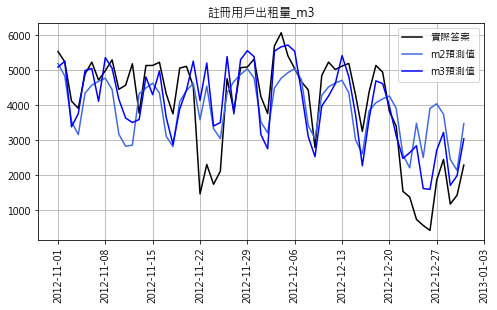

In [121]:
# 繪圖
# 比較 實際出租,m2預測與m3預測
#import matplotlib.datesas mdates
fig,ax=plt.subplots(figsize=(8,4))
datasets_test3=x2_test['ds']
ax.plot(datasets_test3,ytest3,label='實際答案',c='k')
ax.plot(datasets_test3,ypred2,label='m2預測值',c='royalblue')
ax.plot(datasets_test3,ypred3,label='m3預測值',c='b')

weeks=mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(axis='x',rotation=90)

ax.grid()
ax.legend()
ax.set_title('註冊用戶出租量_m3')

plt.show()